In [1]:
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/torch/tuts2', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
# source: https://jonathanbgn.com/2021/08/30/audio-augmentation.html

In [23]:
import torchaudio
# test for gmm-ubm on whale calls
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
from collections import Counter
import numpy as np
import config
import librosa
import utils as my_utils
import feature_extraction.fe_spafe.fe_spafe as fe_spafe
import feature_extraction.fe_base as fe_base
import os.path
reload(fe_base)
reload(fe_spafe)
import my_torch.torchio as tio

In [29]:
# create ads

# female ads
datasetFolder = r"/Users/david/Documents/data/speech/ivectors/SPEECH DATA/FEMALE/MIC"
female_ads = myads.AudioDatastore()
female_ads.populate(datasetFolder, include_sub_folders=True, label_source=True)
Counter(female_ads.labels).values()
# male ads
datasetFolder = r"/Users/david/Documents/data/speech/ivectors/SPEECH DATA/MALE/MIC"
male_ads = myads.AudioDatastore()
male_ads.populate(datasetFolder, include_sub_folders=True, label_source=True)
Counter(male_ads.labels).values()
# combine ads
ads = myads.AudioDatastore()
ads.set([datasetFolder], files=female_ads.files + male_ads.files, labels=female_ads.labels + male_ads.labels)
# split ads
all_labels = ["M01", "M02", "M03", "M04", "M06", "M07", "M08", "M09", "F01", "F02", "F03", "F04", "F06", "F07",
                     "F08", "F09", "M05", "M10", "F05", "F10"]

ads_all = myads.subset(ads, all_labels)

test_wav = ads_all.files[10]

In [38]:
import torch
torch.set_num_threads(1)
model, torch_utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)
(get_speech_timestamps,
 _, read_audio,
 *_) = torch_utils

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /Users/david/.cache/torch/hub/master.zip


In [59]:
audio_data, sample_rate = torchaudio.load(test_wav)
std = torch.std(audio_data) * 10  # 97%
max = torch.max(audio_data)
audio_data = audio_data / std

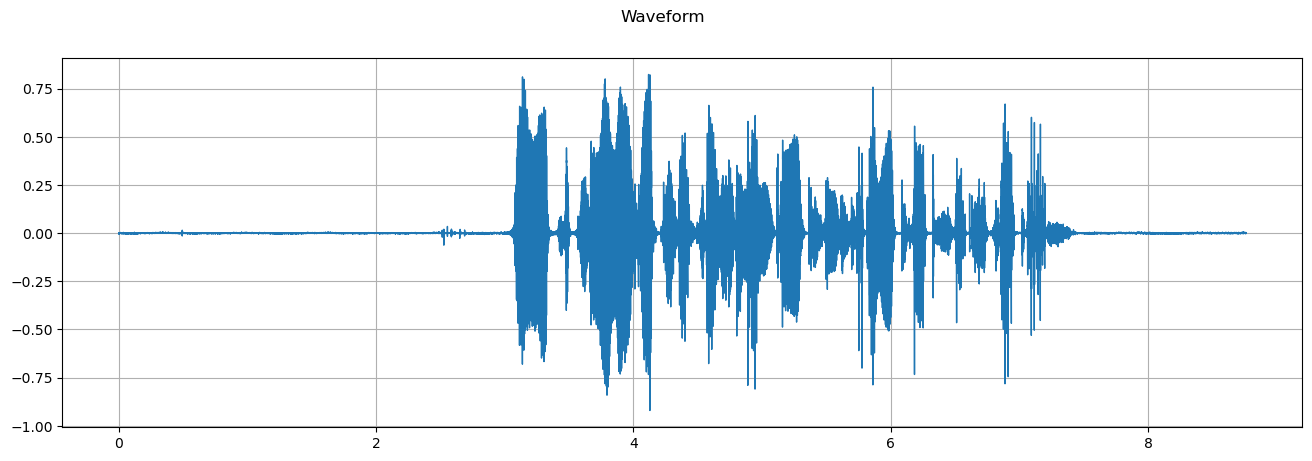

In [60]:
import matplotlib.pyplot as plt
tio.plot_waveform(audio_data, sample_rate)
tio.play_audio(audio_data, sample_rate)

1. Random clipping

In [65]:
import random
import torchaudio

class RandomClip:
    def __init__(self, sample_rate, clip_length):
        self.clip_length = clip_length
        self.vad = torchaudio.transforms.Vad(
            sample_rate=sample_rate, trigger_level=7.0)

    def __call__(self, audio_data):
        audio_length = audio_data.shape[0]
        if audio_length > self.clip_length:
            offset = random.randint(0, audio_length-self.clip_length)
            audio_data = audio_data[offset:(offset+self.clip_length)]

        return self.vad(audio_data) # remove silences at the begining/end

clip_transform = RandomClip(sample_rate, 181280) # 8 seconds clip
transformed_audio = clip_transform(audio_data)

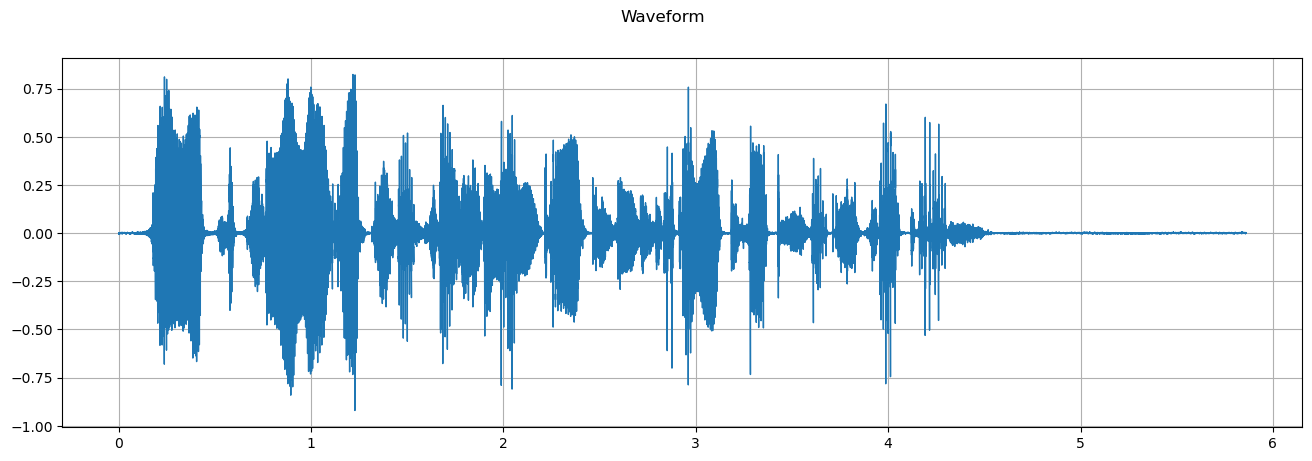

In [66]:
tio.plot_waveform(transformed_audio, sample_rate)
tio.play_audio(transformed_audio, sample_rate)
# not working not sure why

2. Speed perturbation

In [70]:
import random

class RandomSpeedChange:
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate

    def __call__(self, audio_data):
        speed_factor = random.choice([0.9, 1.0, 1.1])
        print(speed_factor)
        if speed_factor == 1.0: # no change
            return audio_data

        # change speed and resample to original rate:
        sox_effects = [
            ["speed", str(speed_factor)],
            ["rate", str(self.sample_rate)],
        ]
        transformed_audio, _ = torchaudio.sox_effects.apply_effects_tensor(
            audio_data, self.sample_rate, sox_effects)
        return transformed_audio


In [71]:
speed_transform = RandomSpeedChange(sample_rate)
transformed_audio = speed_transform(audio_data)

1.1


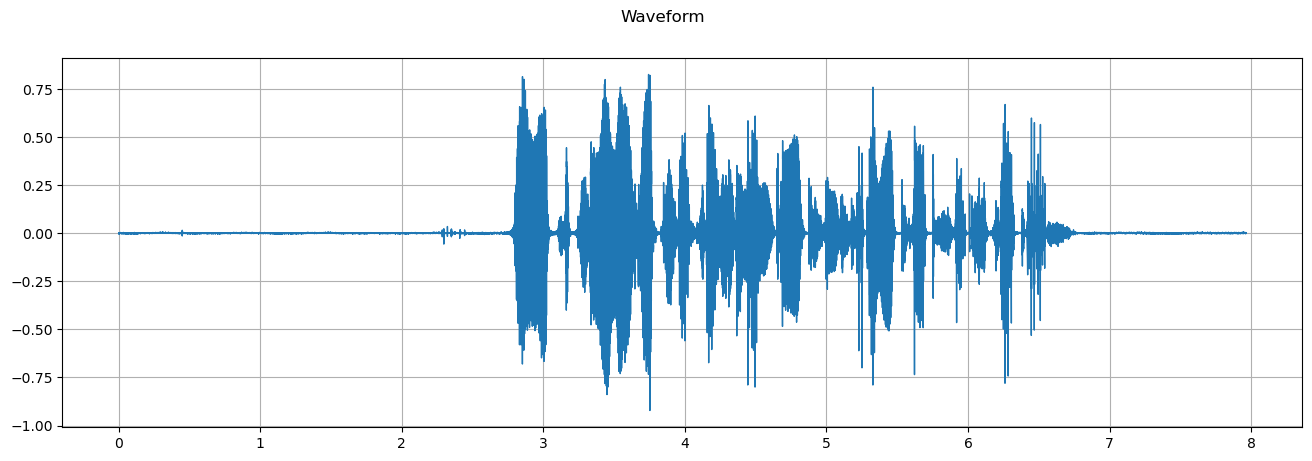

In [72]:
tio.plot_waveform(transformed_audio, sample_rate)
tio.play_audio(transformed_audio, sample_rate)

3. Background noise

In [73]:
import math
import os
import pathlib
import random
import torch

class RandomBackgroundNoise:
    def __init__(self, sample_rate, noise_dir, min_snr_db=0, max_snr_db=15, snr_db=20):
        self.sample_rate = sample_rate
        self.min_snr_db = min_snr_db
        self.max_snr_db = max_snr_db
        self.snr_db = snr_db

        if not os.path.exists(noise_dir):
            raise IOError(f'Noise directory `{noise_dir}` does not exist')
        # find all WAV files including in sub-folders:
        self.noise_files_list = list(pathlib.Path(noise_dir).glob('**/*.wav'))
        if len(self.noise_files_list) == 0:
            raise IOError(f'No .wav file found in the noise directory `{noise_dir}`')

    def __call__(self, audio_data):
        random_noise_file = random.choice(self.noise_files_list)
        effects = [
            ['remix', '1'], # convert to mono
            ['rate', str(self.sample_rate)], # resample
        ]
        noise, _ = torchaudio.sox_effects.apply_effects_file(random_noise_file, effects, normalize=True)
        audio_length = audio_data.shape[-1]
        noise_length = noise.shape[-1]
        # add in noise randomly if longer, or if shorter then zero pad end
        if noise_length > audio_length:
            offset = random.randint(0, noise_length-audio_length)
            noise = noise[..., offset:offset+audio_length]
        elif noise_length < audio_length:
            noise = torch.cat([noise, torch.zeros((noise.shape[0], audio_length-noise_length))], dim=-1)

        snr_db = random.randint(self.min_snr_db, self.max_snr_db)
        snr = math.exp(snr_db / 10)
        audio_power = audio_data.norm(p=2)
        noise_power = noise.norm(p=2)
        scale = snr * noise_power / audio_power

        return (scale * audio_data + noise ) / 2

noise_transform = RandomBackgroundNoise(sample_rate, r'/Users/david/Documents/data/MUSAN/musan/noise/free-sound')
transformed_audio = noise_transform(audio_data)

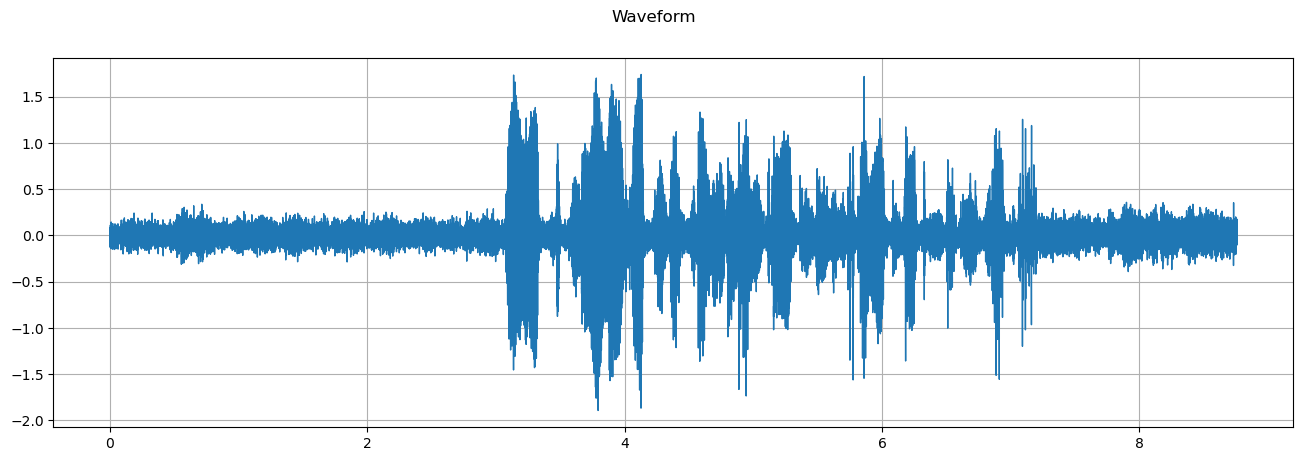

In [74]:
tio.plot_waveform(transformed_audio, sample_rate)
tio.play_audio(transformed_audio, sample_rate)

In [ ]:
# multiple transforms after each other

class ComposeTransform:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, audio_data):
        for t in self.transforms:
            audio_data = t(audio_data)
        return audio_data

compose_transform = ComposeTransform([
    RandomClip(sample_rate=sample_rate,clip_length=64000),
    RandomSpeedChange(sample_rate),
    RandomBackgroundNoise(sample_rate, './noises_directory')])

transformed_audio = compose_transform(audio_data)